In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import sys
sys.path.append("../../../src/")

%matplotlib inline

import nanonets
import nanonets_utils

In [3]:
# Network Parameter
N_electrodes    = 8
N_particles     = 3
N_jumps         = 5000
topology        = {
    "Nx"                : N_particles,
    "Ny"                : N_particles,
    "Nz"                : 1,
    "e_pos"             :  [[0,0,0],[int((N_particles-1)/2),0,0],[N_particles-1,0,0],[0,int((N_particles-1)/2),0],[0,N_particles-1,0],
                            [int((N_particles-1)/2),N_particles-1,0],[N_particles-1,int((N_particles-1)/2),0],[N_particles-1,N_particles-1,0]],
    "electrode_type"    : ['constant','floating','floating','floating','floating','floating','floating','constant']
}
sim_dic         = {
    "error_th"        : 0.0,      
    "max_jumps"       : N_jumps,
    "eq_steps"        : 0,
    "jumps_per_batch" : 1,
    "kmc_counting"    : False,
    "min_batches"     : 1
}

In [150]:
# Voltage Values
N_voltages                  = 1001
U_amplitude                 = 1.0
voltages                    = np.zeros(shape=(N_voltages,N_electrodes+1))
# voltages[:,:N_electrodes]   = np.tile(np.random.uniform(low=-U_amplitude, high=U_amplitude, size=(1,N_electrodes)), (N_voltages,1))
# voltages[:,0]               = np.random.uniform(low=-U_amplitude, high=U_amplitude, size=N_voltages)
voltages[:,0]               = np.linspace(-U_amplitude, U_amplitude, N_voltages, endpoint=True)
# voltages[:,7]               = np.random.uniform(low=-U_amplitude, high=U_amplitude, size=N_voltages)
# voltages[:,:N_electrodes]   = np.random.uniform(low=-U_amplitude, high=U_amplitude, size=(N_voltages,N_electrodes))
voltages

array([[-1.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [-0.998,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [-0.996,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.996,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.998,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

In [151]:
target_electrode    = 7
sim_class           = nanonets.simulation(network_topology='cubic', topology_parameter=topology)
sim_class.run_const_voltages(voltages=voltages, target_electrode=target_electrode, output_potential=True, verbose=True, sim_dic=sim_dic, save_th=0.1)

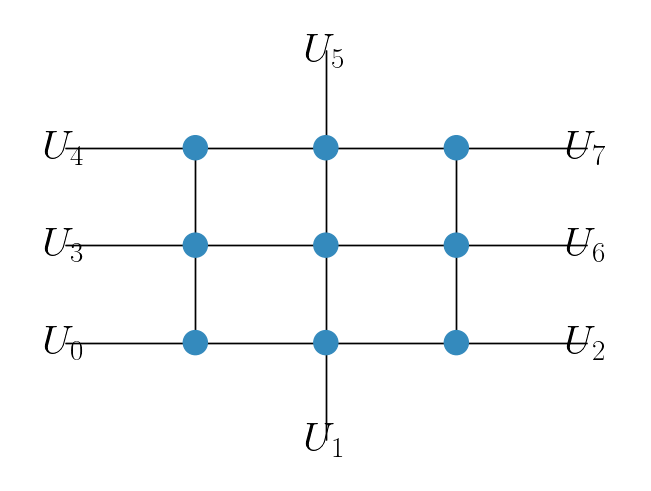

In [5]:
fig     = plt.figure(layout='constrained')
ax      = fig.add_subplot()
sim_class           = nanonets.simulation(network_topology='cubic', topology_parameter=topology)
fig, ax = nanonets_utils.display_network(sim_class, fig, ax, provide_electrode_labels=[f"$U_{i}$" for i in range(N_electrodes)], font_size=30)
fig.savefig(f"plots/network_{N_particles}.svg", transparent=True)

In [153]:
output_vals         = pd.DataFrame(sim_class.return_output_values())
landscape_series    = sim_class.pot_per_it
electrode_votalges  = {i : pd.DataFrame(landscape_series[i]).iloc[:,:8]*1000 for i in range(N_voltages)}
time_vals           = {i : np.cumsum(sim_class.time_values[i])*1e9 for i in range(N_voltages)}
not_finished        = output_vals[output_vals[1] != N_jumps].index

In [154]:
output_vals

,0,1,2,3
0,0.0,5000.0,0.0,0.0
1,0.0,5000.0,0.0,0.0
2,0.0,5000.0,0.0,0.0
3,0.0,5000.0,0.0,0.0
4,0.0,5000.0,0.0,0.0
...,...,...,...,...
996,0.0,5000.0,0.0,0.0
997,0.0,5000.0,0.0,0.0
998,0.0,5000.0,0.0,0.0
999,0.0,5000.0,0.0,0.0


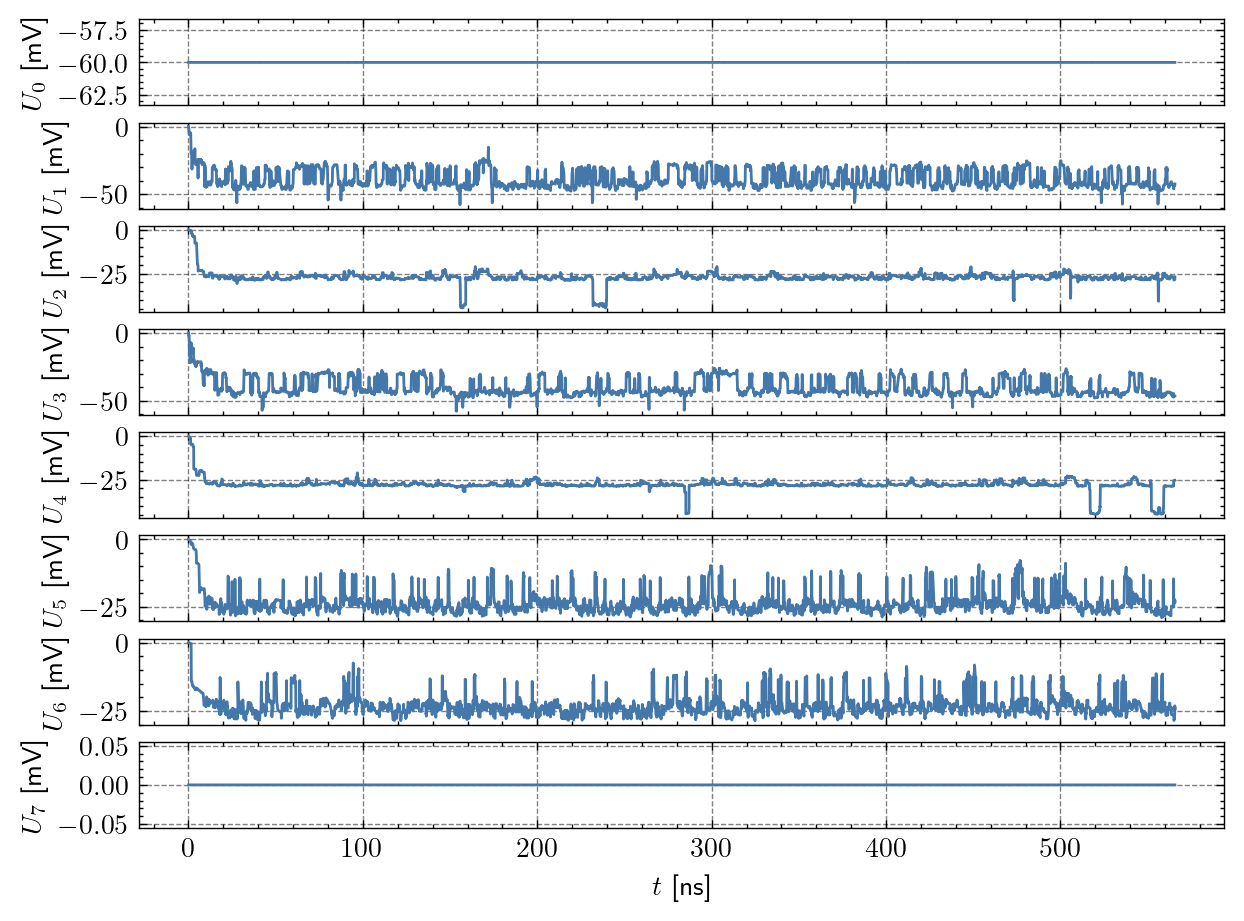

In [155]:
start       = 0
volt_set    = 470

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2.0)
    fig.set_figheight(fig.get_figheight()*2.0)

    for i in range(8):

        ax  = fig.add_subplot(8,1,i+1)
        ax.plot(time_vals[volt_set][start:], electrode_votalges[volt_set].iloc[start:,i])

        # ax.set_xlim(1000,2000)
        if i == 0:
            pass
            # ax.set_ylim(60,65)
        else:
            pass
            # ax.set_ylim(-8,8)

        ax.set_ylabel(f"$U_{i}$ [mV]")

        if i != 7:
            ax.set_xticklabels("")

    ax.set_xlabel("$t$ [ns]")
    fig.savefig(f"plots/output_example_{N_particles}.svg", transparent=True)

## Electrode Voltages / jump=-1 case

In [156]:
volt_not_finished = []
for i in not_finished:
    
    df_tmp              = pd.DataFrame(landscape_series[i]).copy()
    df_tmp.iloc[1:,:7]  = df_tmp.iloc[1:,:7].replace(0, np.nan)
    df_tmp              = df_tmp.dropna()

    try:
        volt_not_finished.append(df_tmp.iloc[-1,:7])
    except:
        print(i)

volt_finished = []
for i in range(N_voltages):

    if i in not_finished:
        continue
    
    df_tmp              = pd.DataFrame(landscape_series[i]).copy()
    df_tmp.iloc[1:,:7]  = df_tmp.iloc[1:,:7].replace(0, np.nan)
    df_tmp              = df_tmp.dropna()

    try:
        volt_finished.append(df_tmp.iloc[-1,:7])
    except:
        print(i)

sum_not_finished    = [(sum(volt)*1000) for volt in volt_not_finished]
sum_finished        = [(sum(volt)*1000) for volt in volt_finished]

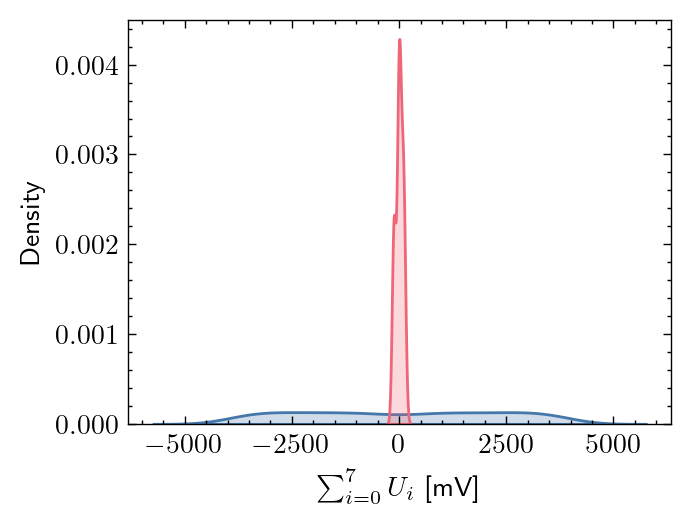

In [157]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)

    ax  = fig.add_subplot()
    ax  = sns.kdeplot(sum_finished, ax=ax, fill=True, bw_adjust=1.0)
    ax  = sns.kdeplot(sum_not_finished, ax=ax, fill=True, bw_adjust=1.0)

    # ax.set_xlim(-500,500)
    ax.set_xlabel("$\sum_{i=0}^{7} U_i$ [mV]")
    fig.savefig(f"plots/volt_comparsion_{N_particles}.svg", transparent=True)

## Electrode Correaltion

In [158]:
start           = 1000
avg_corr_vals   = pd.DataFrame(np.nanmean([electrode_votalges[i].iloc[start:,1:N_electrodes-1].corr() for i in range(N_voltages) if i not in not_finished], axis=0))
matrix          = np.triu(np.ones_like(avg_corr_vals, dtype=bool))
rename_mapper   = {i-1 : f"$U_{i}$" for i in range(1,N_electrodes-1)}
avg_corr_vals   = avg_corr_vals.rename(columns=rename_mapper, index=rename_mapper)

In [159]:
avg_corr_vals

,$U_1$,$U_2$,$U_3$,$U_4$,$U_5$,$U_6$
$U_1$,1.000000,0.552099,0.478964,0.499010,0.475824,0.489242
$U_2$,0.552099,1.000000,0.499981,0.532699,0.506845,0.550979
$U_3$,0.478964,0.499981,1.000000,0.542435,0.484245,0.474942
$U_4$,0.499010,0.532699,0.542435,1.000000,0.550341,0.504517
$U_5$,0.475824,0.506845,0.484245,0.550341,1.000000,0.483572
$U_6$,0.489242,0.550979,0.474942,0.504517,0.483572,1.000000


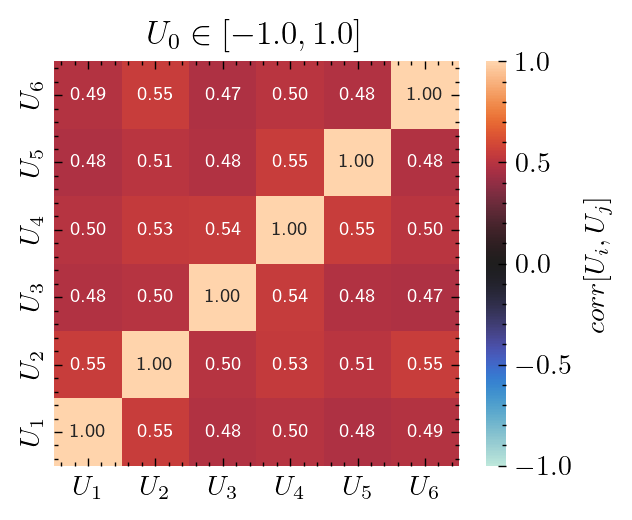

In [160]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.heatmap(avg_corr_vals, vmin=-1.0, vmax=1.0, annot=True, fmt='.2f', center=0, square=True, ax=ax, annot_kws={'size':'x-small'}, cbar_kws={'label':'$corr[U_i,U_j]$'})
    ax.set_title(f"$U_0 \in [{round(voltages[0,0],1)},{round(voltages[1000,0],1)}]$")
    ax.invert_yaxis()

    fig.savefig(f"plots/electrode_correlation_{N_particles}.svg", transparent=True)

## NP Correlation

In [161]:
np_index        = N_particles**2//2
avg_np_corr     = pd.DataFrame(np.mean([np.corrcoef(landscape_series[i][:,N_electrodes:], rowvar=False)[np_index].reshape(N_particles,-1) for i in range(N_voltages) if i not in not_finished], axis=0).reshape(N_particles,-1))
rename_mapper   = {i : f"${i}$" for i in range(N_particles)}
avg_np_corr     = avg_np_corr.rename(columns=rename_mapper, index=rename_mapper)

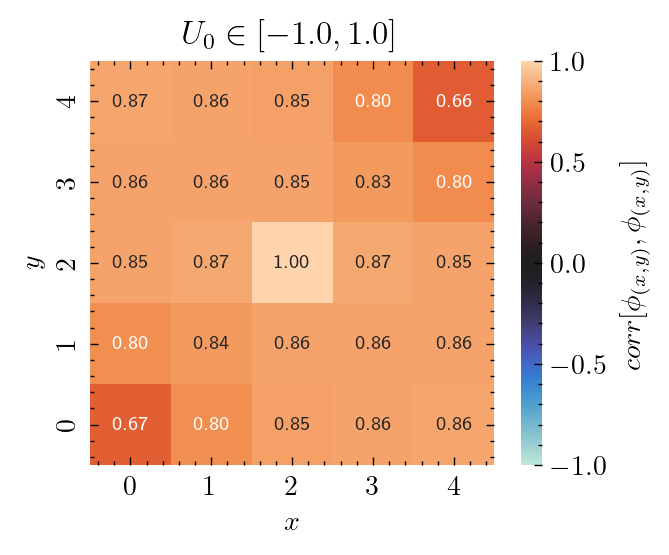

In [162]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.heatmap(avg_np_corr, ax=ax, vmin=-1.0, vmax=1.0, cbar_kws={'label':'$corr[\phi_{(x,y)},\phi_{(x,y)}]$'}, annot=True, fmt='.2f', annot_kws={'size':'x-small'}, center=0, square=True)
    ax.invert_yaxis()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title(f"$U_0 \in [{round(voltages[0,0],1)},{round(voltages[1000,0],1)}]$")
    
    fig.savefig(f"plots/np_correlation_{N_particles}.svg", transparent=True)

## Electrode Correaltion close to Blockade

In [163]:
min_index   = 450
max_index   = 551

In [164]:
start           = 1000
avg_corr_vals   = pd.DataFrame(np.nanmean([electrode_votalges[i].iloc[start:,1:N_electrodes-1].corr() for i in range(N_voltages) if i not in not_finished and i < max_index and i > min_index], axis=0))
rename_mapper   = {i-1 : f"$U_{i}$" for i in range(1,N_electrodes-1)}
avg_corr_vals   = avg_corr_vals.rename(columns=rename_mapper, index=rename_mapper)

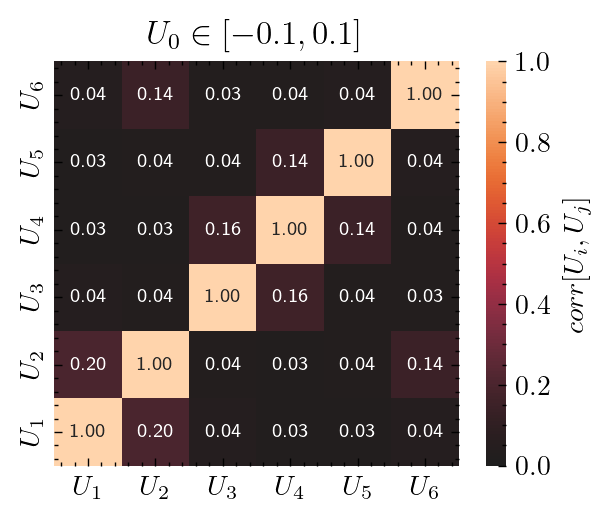

In [165]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.heatmap(avg_corr_vals, vmin=0, vmax=1.0, annot=True, fmt='.2f', center=0, square=True, ax=ax, annot_kws={'size':'x-small'}, cbar_kws={'label':'$corr[U_i,U_j]$'})
    ax.set_title(f"$U_0 \in [{round(voltages[min_index,0],1)},{round(voltages[max_index,0],1)}]$")
    ax.invert_yaxis()
    
    fig.savefig(f"plots/electrode_correlation_blockade_{N_particles}.svg", transparent=True)

## NP Correaltion close to Blockade

In [166]:
np_index        = N_particles**2//2
avg_np_corr     = pd.DataFrame(np.mean([np.corrcoef(landscape_series[i][:,N_electrodes:], rowvar=False)[np_index].reshape(N_particles,-1) for i in range(N_voltages) if i not in not_finished and i < max_index and i > min_index], axis=0).reshape(N_particles,-1))
rename_mapper   = {i : f"${i}$" for i in range(N_particles)}
avg_np_corr     = avg_np_corr.rename(columns=rename_mapper, index=rename_mapper)

In [167]:
N_particles**2//2

12

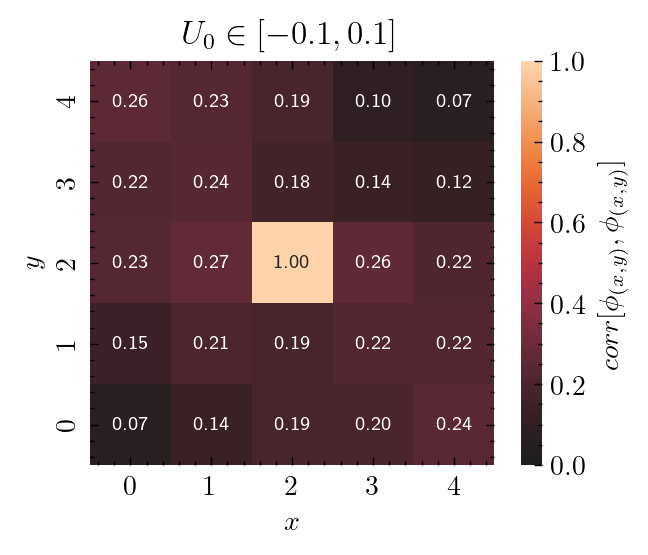

In [168]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.heatmap(avg_np_corr, ax=ax, vmin=0.0, vmax=1.0, cbar_kws={'label':'$corr[\phi_{(x,y)},\phi_{(x,y)}]$'}, annot=True, fmt='.2f', annot_kws={'size':'x-small'}, center=0, square=True)
    ax.invert_yaxis()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title(f"$U_0 \in [{round(voltages[min_index,0],1)},{round(voltages[max_index,0],1)}]$")
    
    fig.savefig(f"plots/np_correlation_blockade_{N_particles}.svg", transparent=True)